In [3]:
import pandas as pd
from scipy import stats
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
data=pd.read_csv('/Users/alexandraburenko/Downloads/ab_test_data.csv', parse_dates= ['timestamp'])
data.info()
display(data.head(5))
data.groupby('test_group').describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19998 entries, 0 to 19997
Data columns (total 4 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   user_id     19998 non-null  object        
 1   timestamp   19998 non-null  datetime64[ns]
 2   test_group  19998 non-null  object        
 3   conversion  19998 non-null  int64         
dtypes: datetime64[ns](1), int64(1), object(2)
memory usage: 625.1+ KB


,user_id,timestamp,test_group,conversion
0,7f6833e6-1141-4f20-b4b2-f1e31019b1fd,2023-07-04 04:40:55.848109,a,0
1,e6a6e960-d3f3-4074-a516-ba1e609b211e,2023-07-06 00:26:45.486187,b,0
2,4d3fbfa5-6847-410a-bac2-477f01d5f400,2023-07-10 20:24:33.639464,b,0
3,361457d9-a044-48f7-981c-d67dc3861679,2023-07-20 07:04:49.957013,b,0
4,285cd63d-7d03-427f-a062-1fa2dd2e77d6,2023-07-19 23:27:50.116680,b,0


timestamp                                 \
               count                           mean   
test_group                                            
a              10013  2023-07-14 02:34:29.519821312   
b               9985  2023-07-13 21:37:07.888925952   

                                                                       \
                                   min                            25%   
test_group                                                              
a           2023-07-03 01:46:14.688840  2023-07-08 13:48:52.874817024   
b           2023-07-03 01:42:34.033708  2023-07-08 08:08:48.495631104   

                                                                          \
                                      50%                            75%   
test_group                                                                 
a           2023-07-14 03:49:36.002731008  2023-07-19 14:06:28.688054016   
b           2023-07-13 19:14:14.073116928  2023-07-19 09:59:58.771382016   

                                            conversion                      \
                                   max  std      count      mean  min  25%   
test_group                                                                   
a           2023-07-25 01:41:19.152664  NaN    10013.0  0.061021  0.0  0.0   
b           2023-07-25 01:35:59.130658  NaN     9985.0  0.089034  0.0  0.0   

                                     
            50%  75%  max       std  
test_group                           
a           0.0  0.0  1.0  0.239380  
b           0.0  0.0  1.0  0.284806



The number of users in groups A and B relatively:

Test_group	a count =  10013

Test_group	b count = 9985



conversion a = 	0.061021 = 6.1 %

conversion b = 0.089034 =  8.9 %


In [8]:
data_filtred = data[data['conversion'] == 1]
conversion_count= data_filtred.groupby('test_group').size()
print(conversion_count)

test_group
a    611
b    889
dtype: int64


**visualization to equalize the mean values ​​in groups with 95% confidence intervals**

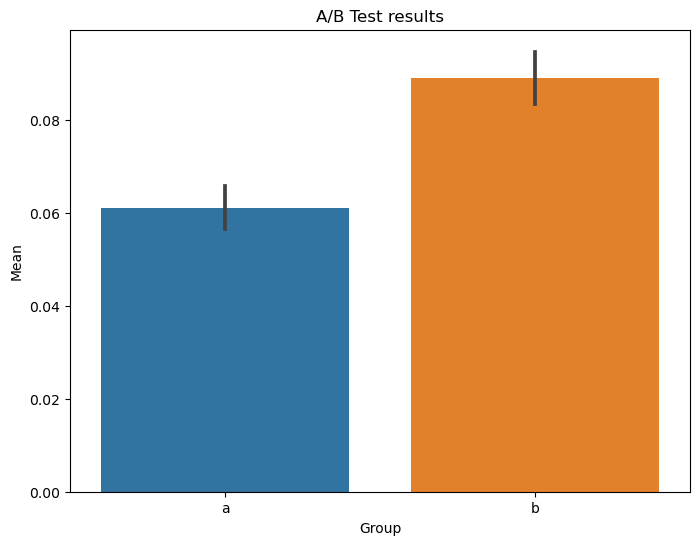

In [11]:
plt.figure(figsize=(8,6))
sns.barplot(x= data['test_group'], y = data['conversion'], errorbar=('ci', 95))
plt.title ('A/B Test results')
plt.xlabel('Group')
plt.ylabel('Mean')
plt.savefig('/Users/alexandraburenko/Desktop/DA/AB Test results.png')
plt.show()


**Graph that shows the change in conversion per hour. **





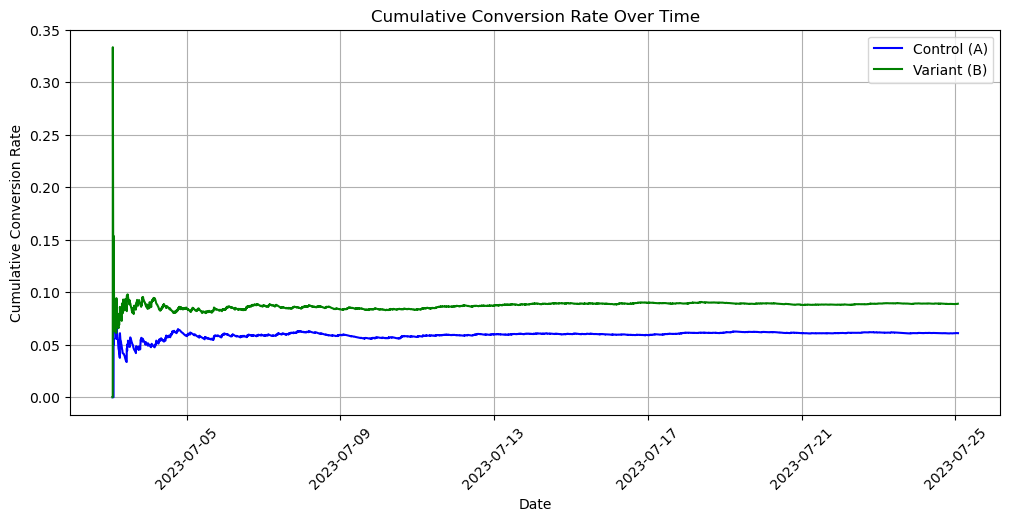

In [24]:
data['date'] = data['timestamp'].dt.date
cumulative_conversion_a = data[data['test_group'] == 'a'].sort_values(by='date')['conversion'].expanding().mean().reset_index(drop=True)
cumulative_conversion_b = data[data['test_group'] == 'b'].sort_values(by='date')['conversion'].expanding().mean().reset_index(drop=True)
cumulative_conversion_a.index = data[data['test_group'] == 'a'].sort_values(by='timestamp')['timestamp'].values
cumulative_conversion_b.index = data[data['test_group'] == 'b'].sort_values(by='timestamp')['timestamp'].values
plt.figure(figsize=(12, 5))
plt.plot(cumulative_conversion_a.index, cumulative_conversion_a, label='Control (A)', color='blue')
plt.plot(cumulative_conversion_b.index, cumulative_conversion_b, label='Variant (B)', color='green')
plt.title('Cumulative Conversion Rate Over Time')
plt.xlabel('Date')
plt.ylabel('Cumulative Conversion Rate')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()

**The date of the beginning and the end date of the dough, as well as the duration of the dough in days**

In [345]:
first_date = data['timestamp'].min()
last_date = data['timestamp'].max()
duration= pd.date_range(start=first_date, end=last_date).shape[0]
print('First_date =', first_date, '\nLast date =', last_date, '\nDuration =', duration)

First_date = 2023-07-03 01:42:34.033708 
Last date = 2023-07-25 01:41:19.152664 
Duration = 22


**Student's t-test**

In [348]:
alpha = 0.05

statistic, pvalue = stats.ttest_ind(data[data['test_group'] == 'a']['conversion'],
                                    data[data['test_group'] == 'b']['conversion'], 
                                    alternative='less')

print(f't-statistic: {round(statistic, 2)}, p-value: {round(pvalue, 2)}')

if pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')


t-statistic: -7.53, p-value: 0.0
The difference is statistically significant, Null Hypothesis is rejected.


**permutation test**

In [351]:
from scipy import stats

def statistic(x, y):
    return stats.ttest_ind(x, y).statistic

alpha = 0.05

x= data[data['test_group'] == 'a']['conversion']
y= data[data['test_group'] == 'b']['conversion']

results = stats.permutation_test((x,y), statistic,  n_resamples=100)

print(f't-statistic: {round(results.statistic, 2)}, p-value: {round(results.pvalue, 2)}')
if pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')
    

t-statistic: -7.53, p-value: 0.02
The difference is statistically significant, Null Hypothesis is rejected.


**Chi-Square (χ²)**

In [354]:
observed = pd.crosstab(data['test_group'].values, (data['conversion'].values))
statistic, pvalue, daf, expected_values=stats.chi2_contingency(observed) 

print(f'statistic: {round(statistic,2)}. pvalue: {round(pvalue,2)}')
                       
if pvalue < alpha:
    print('The difference is statistically significant, Null Hypothesis is rejected.')
else:
    print('The difference is insignificant, Null Hypothesis cannot rejected.')

statistic: 56.14. pvalue: 0.0
The difference is statistically significant, Null Hypothesis is rejected.
